# Классификация с помощью kNN. Кластеризация K-means

Задание 1: К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.

Задание 2: К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.

Задание 3: Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы. 

## Алгоритм kNN

Логичным усовершенствованием алгоритма kNN является добавление соседям весов (так называемое "взвешенное голосование"), зависящих от их порядкового номера или расстояния до классифицируемого объекта (чем ближе объект обучающей выборки, тем больше его вес).

От номера соседа $i$ веса можно определять как:

- $w(i) = q^{i}$,   $q \in (0,1)$;


- $w(i) = \frac{1}{i}$;


- $w(i) = \frac{1}{(i+a)^{b}}$;


- $w(i) = \frac{k + 1 - i}{k}$.


От расстояния $d$ веса можно определять как:

- $w(d) = q^{d}$,   $q \in (0,1)$;


- $w(d) = \frac{1}{(d+a)^{b}}$, брать вес $\frac{1}{d}$ по аналогии с номером соседа - неудачное решение, так как при $d = 0$ вес будет бесконечно большим, что приводит к переобучению


- $w(d) = \begin{cases}
\frac{d(z_{k}, x) - d(z_{i}, x)}{d(z_{k}, x) - d(z_{1}, x)}, & d(z_{k}, x) \neq d(z_{1}, x) \\ 
1, & d(z_{k}, x) = d(z_{1}, x)
\end{cases}$.

Существуют и другие способы вычисления весов.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Загрузим один из "игрушечных" датасетов из sklearn.

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

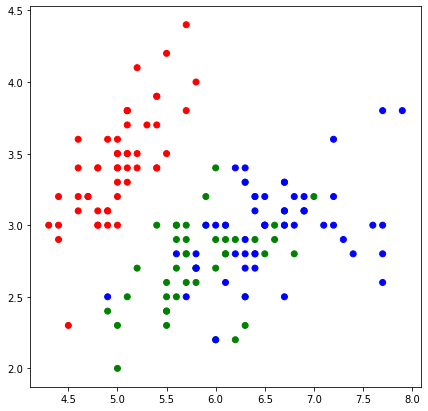

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [5]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [46]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # расчет веса по номеру объекта
            if i == 0:
                num_weith = 1/1e-5
            else:
                num_weith = 1/i
            
            
            # расчет веса по расстоянию до объекта 
            if distance == 0:
                weith_distance = 1/1e-5
            else:
                weith_distance = 1/distance
            
            
            # Записываем в список значение расстояния, весов и ответа на объекте обучающей выборки
            test_distances.append((distance, num_weith, weith_distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[3]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [47]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [48]:
k = 1

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 1: 0.700


Построим график распределения классов.

In [38]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

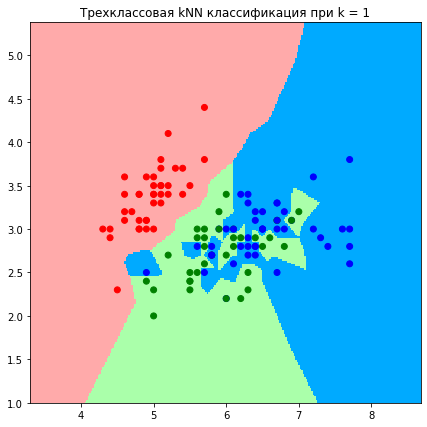

In [39]:
get_graph(X_train, y_train, k)

In [49]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.700


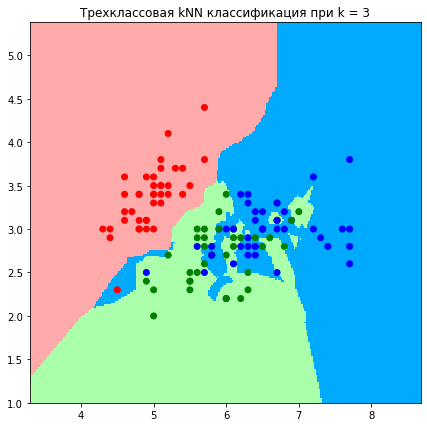

In [41]:
get_graph(X_train, y_train, k)

In [50]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.833


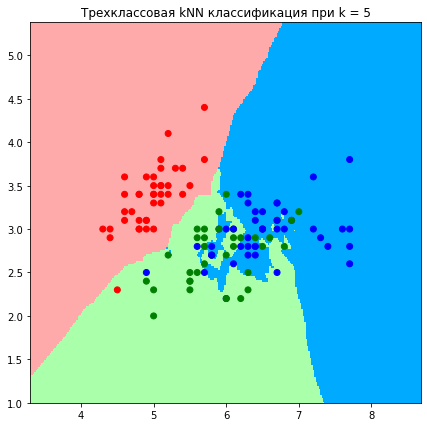

In [43]:
get_graph(X_train, y_train, k)

In [51]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.833


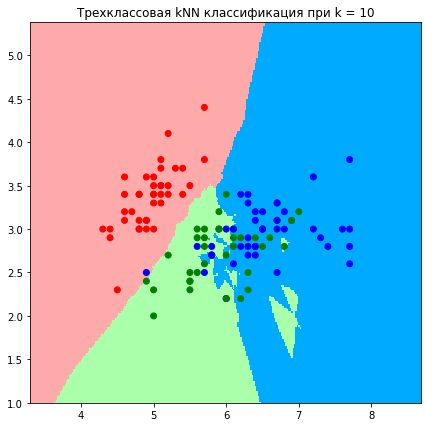

In [45]:
get_graph(X_train, y_train, k)

При k=5 и k=10 точность алгоритма равна, когда k=3 точность меньше, оптимальным значением k будет 5. 